In [1]:
%matplotlib inline
import utils
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import librosa
import librosa.display
import missingno as msno 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
# importing warning in order to ignore them
import warnings 
warnings.filterwarnings('always')   #suppresses all warnings
warnings.filterwarnings('ignore')

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks= utils.load(''/Users/david/Desktop/DM2 project/fma_metadata/tracks.csv')
genres= utils.load('/Users/david/Desktop/DM2 project/fma_metadata/genres.csv')
features= utils.load('/Users/david/Desktop/DM2 project/fma_metadata/features.csv')
echonest= utils.load('/Users/david/Desktop/DM2 project/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

SyntaxError: invalid syntax (<ipython-input-2-755eeadff360>, line 4)

In [ ]:
tracks_cut=['album','artist']
tracks.drop(tracks_cut,axis=1,inplace=True)
tracks.shape

In [ ]:
tracks=tracks.droplevel(0,axis=1)

In [ ]:
tracks_cut=['composer','comments', 'date_created','date_recorded',
            'license','number','title','language_code',
            'publisher', 'tags','information','lyricist','genres','genres_all',
            'favorites','listens','interest','bit_rate', 'duration']
tracks.drop(tracks_cut,axis=1,inplace=True)

In [ ]:
df_target=features[['spectral_rolloff','spectral_centroid']]

In [ ]:
df_target=df_target.droplevel(0,axis=1)

In [ ]:
df_target.columns=['roll_kurtosis','roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std',
                   'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
                   
                   #'bandw_kurtosis','bandw_max','bandw_mean','bandw_median','bandw_min','bandw_skew','bandw_std']
df_target.head()

In [ ]:
df=pd.merge(tracks,df_target, on='track_id')

In [ ]:
df.drop(index=df[df.subset=='large'].index, inplace=True)

# Pre-processing

In [ ]:
train = df.index[df['split'] == 'training']
val = df.index[df['split'] == 'validation']
test = df.index[df['split'] == 'test']

In [ ]:
#copy dataframe
df_enc=df.copy()

In [ ]:
le=LabelEncoder()
ple= preprocessing.LabelEncoder()
df_enc['genre_top']=le.fit_transform(df_enc['genre_top'])

In [ ]:
df_enc['genre_top'].unique()

In [ ]:
replace_values=[ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1,  8,  3]
df_enc['genre_top']=df_enc['genre_top'].replace(replace_values,0)
df_enc['genre_top']=df_enc['genre_top'].replace(11,1)

In [ ]:
y_train = df_enc['genre_top'].loc[df_enc['split'] == 'training']
y_val = df_enc['genre_top'].loc[df_enc['split'] == 'validation']
y_test = df_enc['genre_top'].loc[df_enc['split'] == 'test']
y_train.shape, y_val.shape, y_test.shape

In [ ]:
X=df_enc.drop('genre_top',axis=1)

In [ ]:
X_train = X.loc[X['split'] == 'training']
X_val = X.loc[X['split'] == 'validation']
X_test = X.loc[X['split'] == 'test']
X_train.shape, X_val.shape, X_test.shape

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
cut_columns=['split','subset',]#'genres_all'
X_train.drop(cut_columns,axis=1,inplace=True)
X_val.drop(cut_columns,axis=1,inplace=True)
X_test.drop(cut_columns,axis=1,inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#normalize data with Robust scaler
#scaler = RobustScaler()
#scaler.fit_transform(X_train)
#scaler.fit_transform(X_val)
#scaler.fit_transform(X_test)

In [ ]:
y_train.shape

# OUTLIER DETECTION

In [ ]:
#task:rimuovere l'1% degli outliers:
outlier_fraction = 0.1
#andremo a cercare slamente l'1% degli outliers e li rimuoveremo o sostituiremo in seguito

In [ ]:
from pyod.models.abod import ABOD

In [ ]:
abod=ABOD(contamination=outlier_fraction)
abod.fit(X_train)

In [ ]:
abod_anomalies = abod.predict(X_train)
np.unique(abod_anomalies, return_counts=True)

In [ ]:
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outliers= X_train[abod_anomalies==1]
X_train.shape

In [ ]:
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outlier= X_train[abod_anomalies==1]
X_train1, y_train1 = X_train.iloc[abod_inlier, :], y_train.iloc[abod_inlier]
# summarize the shape of the updated training dataset
print(X_train1.shape, y_train1.shape)

In [ ]:
y_train.shape

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
iso = IsolationForest(max_samples=100,random_state=42, contamination=0.1) 
iso.fit(X_train)
if_anomalies=iso.predict(X_train)

In [ ]:
np.unique(if_anomalies,return_counts=True)

In [ ]:
# select all rows that are not outliers
if_inlier=if_anomalies!=-1
if_outlier=X_train[if_anomalies==-1]
X_train4, y_train4 = X_train.iloc[if_inlier, :], y_train.iloc[if_inlier]
# summarize the shape of the updated training dataset
print(X_train4.shape, y_train4.shape)

In [ ]:
y_train.shape

In [ ]:
if_indexes=if_outlier.index.tolist()
abod_indexes=abod_outlier.index.tolist()

In [ ]:
#comparison if with abod
count_if_abod=0
for i in set(if_indexes).intersection(set(abod_indexes)):
    count_if_abod= count_if_abod+1
print(count_if_abod) 

In [ ]:
X_train_clean=X_train.copy()
y_train_clean=y_train.copy()

In [ ]:
for index in set(if_indexes).intersection(set(abod_indexes)):
    X_train_clean.drop(index,inplace=True)
    y_train_clean.drop(index, inplace=True)
print('Dataset before outliers removed:',X_train.shape, y_train.shape)
print('Dataset cleaned:', X_train_clean.shape, y_train_clean.shape)

In [ ]:
X_train=X_train_clean
y_train=y_train_clean
X_train.shape,y_train.shape

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score 


In [42]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

### Validation

In [56]:
y_val_pred = clf.predict(X_val)

In [57]:
print('Accuracy %s' % accuracy_score(y_val, y_val_pred))
print('F1-score %s' % f1_score(y_val, y_val_pred, average=None))
print(classification_report(y_val, y_val_pred))

Accuracy 0.9337325349301397
F1-score [0.96516995 0.31967213]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2454
           1       0.20      0.76      0.32        51

    accuracy                           0.93      2505
   macro avg       0.60      0.85      0.64      2505
weighted avg       0.98      0.93      0.95      2505



In [58]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr,tpr,_=roc_curve(y_val,y_val_pred)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8509755980631861


[[2300  154]
 [  12   39]]


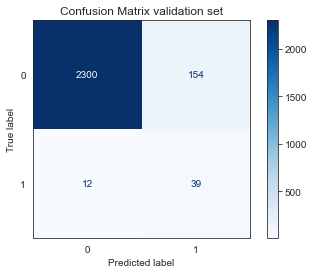

In [59]:
from sklearn.metrics import plot_confusion_matrix
sns.set_style('white')

disp = plot_confusion_matrix(clf,X_val,y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix validation set')
print(disp.confusion_matrix)
plt.show()

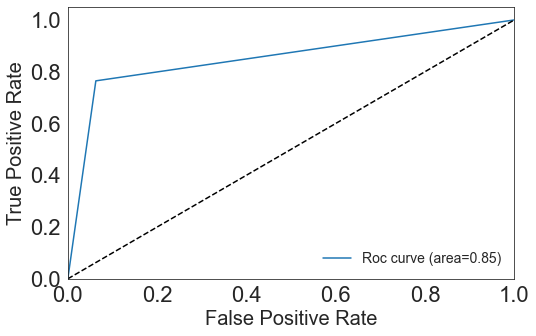

In [60]:
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

### Test set

In [50]:
y_pred = clf.predict(X_test)

In [51]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9467547609794015
F1-score [0.97220532 0.36866359]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2522
           1       0.24      0.78      0.37        51

    accuracy                           0.95      2573
   macro avg       0.62      0.87      0.67      2573
weighted avg       0.98      0.95      0.96      2573



In [52]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8671766882803874


[[2396  126]
 [  11   40]]


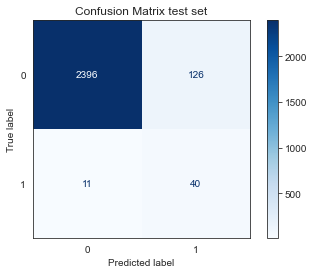

In [53]:
from sklearn.metrics import plot_confusion_matrix
sns.set_style('white')

disp = plot_confusion_matrix(clf,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set')
print(disp.confusion_matrix)
plt.show()

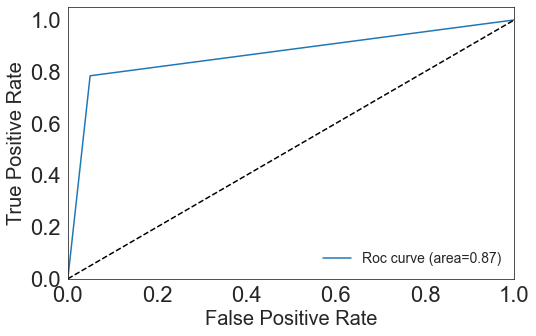

In [54]:
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

# Random Oversamling

In [73]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [74]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 18808, 1: 18808})


In [75]:
clf.fit(X_res, y_res)

y_pred_random = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_random))
print('F1-score %s' % f1_score(y_test, y_pred_random, average=None))
print(classification_report(y_test, y_pred_random))
print(confusion_matrix(y_test,y_pred_random))

Accuracy 0.9078896230081617
F1-score [0.95086046 0.26625387]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2522
           1       0.16      0.84      0.27        51

    accuracy                           0.91      2573
   macro avg       0.58      0.88      0.61      2573
weighted avg       0.98      0.91      0.94      2573

[[2293  229]
 [   8   43]]


# CondenseNearestNeighbour

In [76]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [77]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res_cnn, y_res_cnn = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res_cnn))

Resampled dataset shape Counter({0: 585, 1: 371})


In [78]:
clf.fit(X_res_cnn, y_res_cnn)

dt_pred_cnn = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, dt_pred_cnn))
print('F1-score %s' % f1_score(y_test, dt_pred_cnn, average=None))
print(classification_report(y_test, dt_pred_cnn))
print(confusion_matrix(y_test,dt_pred_cnn))

Accuracy 0.9626894675476098
F1-score [0.98069964 0.44186047]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2522
           1       0.31      0.75      0.44        51

    accuracy                           0.96      2573
   macro avg       0.65      0.86      0.71      2573
weighted avg       0.98      0.96      0.97      2573

[[2439   83]
 [  13   38]]


In [79]:
fpr_random,tpr_random,_=roc_curve(y_test,y_pred_random)
roc_auc_random=auc(fpr_random,tpr_random)
print(roc_auc_random)

0.8761681516381334


In [80]:
fpr_cnn,tpr_cnn,_=roc_curve(y_test,dt_pred_cnn)
roc_auc_cnn=auc(fpr_cnn,tpr_cnn)
print(roc_auc_cnn)

0.8560938253175973


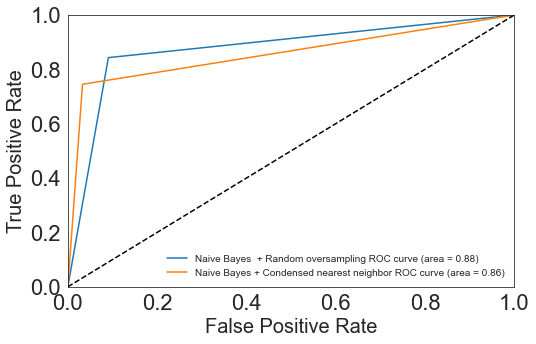

In [82]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_random, tpr_random, label='Naive Bayes  + Random oversampling ROC curve (area = %0.2f)' % (roc_auc_random))
plt.plot(fpr_cnn, tpr_cnn, label='Naive Bayes + Condensed nearest neighbor ROC curve (area = %0.2f)' % (roc_auc_cnn))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.show()

# CN2

In [ ]:
import Orange

In [ ]:
titanic = Orange.data.Table("titanic")

In [ ]:
titanic

In [ ]:
cn2_learner = Orange.classification.rules.CN2Learner()
cn2_classifier = cn2_learner(titanic)

In [ ]:
for r in cn2_classifier.rule_list:
    print(r)

In [ ]:
Orange.data.Domain([Orange.data.Variable(c, compute_value=None) for c in df.columns])

In [ ]:
data = Orange.data.Table.from_numpy(domain=np.array(df.columns), X=X_train, Y=y_train)

In [ ]:
print(data.columns)

In [ ]:
data.__dict__

In [ ]:
cn2_learner = Orange.classification.rules.CN2Learner()
cn2_classifier = cn2_learner(data)

In [ ]:
for r in cn2_classifier.rule_list:
    print(r)